# Schedule Access Plan Outlier Recommendation

This notebook is dedicated to model fitting in terms of database access plans. Access plans here are a representation for a particular query syntax, composed of underlying relational operators as to how data will be retrieved. This experiment deals with plan aggregation. Particularly, plans will be aggregated (summed) into a vector representation, which will then be gauged as an inlier or an outlier. Therefore the work contained within this experiment deals with flagging query access plans as eligable for further analysis - in our case, further analysis as to which optimizer statistics should be gathered.

It should however be noted that this experiment poses a limitation. Access plans here are merely aggregated into a singular vector, representative of the underlying query cost. This aggregation does not indicate which sub-elements of the query are denoted as excessively expensive - this work is carried out in another experiment entirely.

## Query to Access Plan Representation


Each query undergoes a set of processing steps when executed against a database instance. Apart from syntax and semantic checks which are carried out on the input syntax, a number of access plans are generated. Only one plan is chosen, based on the Cost Based Optimizer's decision in an effort to choose the least expensive one.

<div style="width:image width px; font-size:80%; text-align:center;"><img src='Images/Query_translation.png' alt="alternate text" width="width" height="height" style="padding-bottom:0.5em;" /><b>Query Translation Process</b></div>

The query access plan is composed in a tree-like structure, where in each node of the tree acts as a row source. Each step of the access plan either retrieves rows from the database, or accepts rows from one or more row sources as input. The following example is extracted from - https://docs.oracle.com/database/121/TGSQL/tgsql_sqlproc.htm#TGSQL186

In [1]:
%%capture
"""
SELECT e.last_name, j.job_title, d.department_name 
FROM   hr.employees e, hr.departments d, hr.jobs j
WHERE  e.department_id = d.department_id
AND    e.job_id = j.job_id
AND    e.last_name LIKE 'A%';
Execution Plan
Plan hash value: 975837011

--------------------------------------------------------------------------------
| Id| Operation                     | Name        |Rows|Bytes|Cost(%CPU)|Time  |
| 0 | SELECT STATEMENT              |             |  3 | 189 | 7(15)| 00:00:01 |
|*1 |  HASH JOIN                    |             |  3 | 189 | 7(15)| 00:00:01 |
|*2 |   HASH JOIN                   |             |  3 | 141 | 5(20)| 00:00:01 |
| 3 |    TABLE ACCESS BY INDEX ROWID| EMPLOYEES   |  3 |  60 | 2 (0)| 00:00:01 |
|*4 |     INDEX RANGE SCAN          | EMP_NAME_IX |  3 |     | 1 (0)| 00:00:01 |
| 5 |    TABLE ACCESS FULL          | JOBS        | 19 | 513 | 2 (0)| 00:00:01 |
| 6 |   TABLE ACCESS FULL           | DEPARTMENTS | 27 | 432 | 2 (0)| 00:00:01 |

--------------------------------------------------------------------------------
Predicate Information (identified by operation id):
 
   1 - access("E"."DEPARTMENT_ID"="D"."DEPARTMENT_ID")
   2 - access("E"."JOB_ID"="J"."JOB_ID")
   4 - access("E"."LAST_NAME" LIKE 'A%')
       filter("E"."LAST_NAME" LIKE 'A%')
"""

<div style="width:image width px; font-size:80%; text-align:center;"><img src='Images/Row_source_tree.png' alt="alternate text" width="width" height="height" style="padding-bottom:0.5em;" /><b>Access Plan Row Source Tree Representation</b></div>

In [2]:
# pandas
import pandas as pd
print('pandas: %s' % pd.__version__)
# numpy
import numpy as np
print('numpy: %s' % np.__version__)
# matplotlib
import matplotlib.pyplot as plt
# sklearn
import sklearn as sk
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
print('sklearn: %s' % sk.__version__)

pandas: 0.24.1
numpy: 1.16.1
sklearn: 0.19.0


### Configuration Cell

Tweak parametric changes from this cell to influence outcome of experiment

In [3]:
# Experiment Config
tpcds='TPCDS10' # Schema upon which to operate test
test_split=.2
y_labels = ['COST',
            'CARDINALITY',
            'BYTES',
            'CPU_COST',
            'IO_COST',
            'TEMP_SPACE',
            'TIME']
nrows = 10000
dtype={'COST':'int64',
       'CARDINALITY':'int64',
       'BYTES':'int64',
       'CPU_COST':'int64',
       'IO_COST':'int64',
       'TEMP_SPACE':'int64',
       'TIME':'int64'}
black_list = ['TIMESTAMP','SQL_ID'] # Columns which will be ignored during type conversion, and later used for aggregation

# Random Forest Config
parallel_degree = 4
n_estimators = 500
max_depth = 7
criterion='gini'

# Isolation Forest Config
contamination = .05

### Read data from file into pandas dataframes

In [4]:
# Root path
base_dir = 'C:/Users/gabriel.sammut/University/'
#base_dir = 'D:/Projects/ICS5200/'
root_dir = base_dir + 'Data_ICS5200/Schedule/' + tpcds
src_dir = base_dir + 'ICS5200/src/sql/Runtime/TPC-DS/' + tpcds + '/Variants/'

rep_vsql_plan_path = root_dir + '/rep_vsql_plan.csv'
#rep_vsql_plan_path = root_dir + '/rep_vsql_plan.csv'

rep_vsql_plan_df = pd.read_csv(rep_vsql_plan_path,nrows=nrows,dtype=dtype)
print(rep_vsql_plan_df.head())

def prettify_header(headers):
    """
    Cleans header list from unwated character strings
    """
    header_list = []
    [header_list.append(header.replace("(","").replace(")","").replace("'","").replace(",","")) for header in headers]
    return header_list

rep_vsql_plan_df.columns = prettify_header(rep_vsql_plan_df.columns.values)
print('------------------------------------------')
print(rep_vsql_plan_df.columns)

    ('DBID',)    ('SQL_ID',)  ('PLAN_HASH_VALUE',)  ('ID',)    ('OPERATION',)  \
0  2634225673  9jrzzvpgammqz            1147771029        0  SELECT STATEMENT   
1  2634225673  9jrzzvpgammqz            1147771029        1              SORT   
2  2634225673  9jrzzvpgammqz            1147771029        2    PX COORDINATOR   
3  2634225673  9jrzzvpgammqz            1147771029        3           PX SEND   
4  2634225673  9jrzzvpgammqz            1147771029        4              SORT   

  ('OPTIONS',) ('OBJECT_NODE',)  ('OBJECT#',) ('OBJECT_OWNER',)  \
0          NaN              NaN           NaN               NaN   
1    AGGREGATE              NaN           NaN               NaN   
2          NaN              NaN           NaN               NaN   
3  QC (RANDOM)           :Q1000           NaN               SYS   
4    AGGREGATE           :Q1000           NaN               NaN   

  ('OBJECT_NAME',)  ... ('ACCESS_PREDICATES',) ('FILTER_PREDICATES',)  \
0              NaN  ...              

### Read outlier data from file into pandas dataframes and concatenate

In [5]:
#
# CSV Outlier Paths
outlier_hints_q5_path = src_dir + 'hints/output/query_5.csv'
outlier_hints_q10_path = src_dir + 'hints/output/query_10.csv'
outlier_hints_q14_path = src_dir + 'hints/output/query_14.csv'
outlier_hints_q18_path = src_dir + 'hints/output/query_18.csv'
outlier_hints_q22_path = src_dir + 'hints/output/query_22.csv'
outlier_hints_q27_path = src_dir + 'hints/output/query_27.csv'
outlier_hints_q35_path = src_dir + 'hints/output/query_35.csv'
outlier_hints_q36_path = src_dir + 'hints/output/query_36.csv'
outlier_hints_q51_path = src_dir + 'hints/output/query_51.csv'
outlier_hints_q67_path = src_dir + 'hints/output/query_67.csv'
outlier_hints_q70_path = src_dir + 'hints/output/query_70.csv'
outlier_hints_q77_path = src_dir + 'hints/output/query_77.csv'
outlier_hints_q80_path = src_dir + 'hints/output/query_80.csv'
outlier_hints_q86_path = src_dir + 'hints/output/query_86.csv'
#
outlier_predicates_q5_path = src_dir + 'predicates/output/query_5.csv'
outlier_predicates_q10_path = src_dir + 'predicates/output/query_10.csv'
outlier_predicates_q14_path = src_dir + 'predicates/output/query_14.csv'
outlier_predicates_q18_path = src_dir + 'predicates/output/query_18.csv'
outlier_predicates_q22_path = src_dir + 'predicates/output/query_22.csv'
outlier_predicates_q27_path = src_dir + 'predicates/output/query_27.csv'
outlier_predicates_q35_path = src_dir + 'predicates/output/query_35.csv'
outlier_predicates_q36_path = src_dir + 'predicates/output/query_36.csv'
outlier_predicates_q51_path = src_dir + 'predicates/output/query_51.csv'
outlier_predicates_q67_path = src_dir + 'predicates/output/query_67.csv'
outlier_predicates_q70_path = src_dir + 'predicates/output/query_70.csv'
outlier_predicates_q77_path = src_dir + 'predicates/output/query_77.csv'
outlier_predicates_q80_path = src_dir + 'predicates/output/query_80.csv'
outlier_predicates_q86_path = src_dir + 'predicates/output/query_86.csv'
#
outlier_rownum_q5_path = src_dir + 'rownum/output/query_5.csv'
outlier_rownum_q10_path = src_dir + 'rownum/output/query_10.csv'
outlier_rownum_q14_path = src_dir + 'rownum/output/query_14.csv'
outlier_rownum_q18_path = src_dir + 'rownum/output/query_18.csv'
outlier_rownum_q22_path = src_dir + 'rownum/output/query_22.csv'
outlier_rownum_q27_path = src_dir + 'rownum/output/query_27.csv'
outlier_rownum_q35_path = src_dir + 'rownum/output/query_35.csv'
outlier_rownum_q36_path = src_dir + 'rownum/output/query_36.csv'
outlier_rownum_q51_path = src_dir + 'rownum/output/query_51.csv'
outlier_rownum_q67_path = src_dir + 'rownum/output/query_67.csv'
outlier_rownum_q70_path = src_dir + 'rownum/output/query_70.csv'
outlier_rownum_q77_path = src_dir + 'rownum/output/query_77.csv'
outlier_rownum_q80_path = src_dir + 'rownum/output/query_80.csv'
outlier_rownum_q86_path = src_dir + 'rownum/output/query_86.csv'
#
# Read CSV Paths
outlier_hints_q5_df = pd.read_csv(outlier_hints_q5_path,dtype=str)
outlier_hints_q10_df = pd.read_csv(outlier_hints_q10_path,dtype=str)
outlier_hints_q14_df = pd.read_csv(outlier_hints_q14_path,dtype=str)
outlier_hints_q18_df = pd.read_csv(outlier_hints_q18_path,dtype=str)
outlier_hints_q22_df = pd.read_csv(outlier_hints_q22_path,dtype=str)
outlier_hints_q27_df = pd.read_csv(outlier_hints_q27_path,dtype=str)
outlier_hints_q35_df = pd.read_csv(outlier_hints_q35_path,dtype=str)
outlier_hints_q36_df = pd.read_csv(outlier_hints_q36_path,dtype=str)
outlier_hints_q51_df = pd.read_csv(outlier_hints_q51_path,dtype=str)
outlier_hints_q67_df = pd.read_csv(outlier_hints_q67_path,dtype=str)
outlier_hints_q70_df = pd.read_csv(outlier_hints_q70_path,dtype=str)
outlier_hints_q77_df = pd.read_csv(outlier_hints_q77_path,dtype=str)
outlier_hints_q80_df = pd.read_csv(outlier_hints_q80_path,dtype=str)
outlier_hints_q86_df = pd.read_csv(outlier_hints_q86_path,dtype=str)
#
outlier_predicates_q5_df = pd.read_csv(outlier_predicates_q5_path,dtype=str)
outlier_predicates_q10_df = pd.read_csv(outlier_predicates_q10_path,dtype=str)
outlier_predicates_q14_df = pd.read_csv(outlier_predicates_q14_path,dtype=str)
outlier_predicates_q18_df = pd.read_csv(outlier_predicates_q18_path,dtype=str)
outlier_predicates_q22_df = pd.read_csv(outlier_predicates_q22_path,dtype=str)
outlier_predicates_q27_df = pd.read_csv(outlier_predicates_q27_path,dtype=str)
outlier_predicates_q35_df = pd.read_csv(outlier_predicates_q35_path,dtype=str)
outlier_predicates_q36_df = pd.read_csv(outlier_predicates_q36_path,dtype=str)
outlier_predicates_q51_df = pd.read_csv(outlier_predicates_q51_path,dtype=str)
outlier_predicates_q67_df = pd.read_csv(outlier_predicates_q67_path,dtype=str)
outlier_predicates_q70_df = pd.read_csv(outlier_predicates_q70_path,dtype=str)
outlier_predicates_q77_df = pd.read_csv(outlier_predicates_q77_path,dtype=str)
outlier_predicates_q80_df = pd.read_csv(outlier_predicates_q80_path,dtype=str)
outlier_predicates_q86_df = pd.read_csv(outlier_predicates_q86_path,dtype=str)
#
outlier_rownum_q5_df = pd.read_csv(outlier_rownum_q5_path,dtype=str)
outlier_rownum_q10_df = pd.read_csv(outlier_rownum_q10_path,dtype=str)
outlier_rownum_q14_df = pd.read_csv(outlier_rownum_q14_path,dtype=str)
outlier_rownum_q18_df = pd.read_csv(outlier_rownum_q18_path,dtype=str)
outlier_rownum_q22_df = pd.read_csv(outlier_rownum_q22_path,dtype=str)
outlier_rownum_q27_df = pd.read_csv(outlier_rownum_q27_path,dtype=str)
outlier_rownum_q35_df = pd.read_csv(outlier_rownum_q35_path,dtype=str)
outlier_rownum_q36_df = pd.read_csv(outlier_rownum_q36_path,dtype=str)
outlier_rownum_q51_df = pd.read_csv(outlier_rownum_q51_path,dtype=str)
outlier_rownum_q67_df = pd.read_csv(outlier_rownum_q67_path,dtype=str)
outlier_rownum_q70_df = pd.read_csv(outlier_rownum_q70_path,dtype=str)
outlier_rownum_q77_df = pd.read_csv(outlier_rownum_q77_path,dtype=str)
outlier_rownum_q80_df = pd.read_csv(outlier_rownum_q80_path,dtype=str)
outlier_rownum_q86_df = pd.read_csv(outlier_rownum_q86_path,dtype=str)
#
# Merge dataframes into a single pandas matrix
df_outliers = pd.concat([outlier_hints_q5_df, outlier_hints_q10_df], sort=False)
df_outliers = pd.concat([df_outliers, outlier_hints_q14_df], sort=False)
df_outliers = pd.concat([df_outliers, outlier_hints_q18_df], sort=False)
df_outliers = pd.concat([df_outliers, outlier_hints_q22_df], sort=False)
df_outliers = pd.concat([df_outliers, outlier_hints_q27_df], sort=False)
df_outliers = pd.concat([df_outliers, outlier_hints_q35_df], sort=False)
df_outliers = pd.concat([df_outliers, outlier_hints_q36_df], sort=False)
df_outliers = pd.concat([df_outliers, outlier_hints_q51_df], sort=False)
df_outliers = pd.concat([df_outliers, outlier_hints_q67_df], sort=False)
df_outliers = pd.concat([df_outliers, outlier_hints_q70_df], sort=False)
df_outliers = pd.concat([df_outliers, outlier_hints_q77_df], sort=False)
df_outliers = pd.concat([df_outliers, outlier_hints_q80_df], sort=False)
df_outliers = pd.concat([df_outliers, outlier_hints_q86_df], sort=False)
#
df_outliers = pd.concat([df_outliers, outlier_predicates_q5_df], sort=False)
df_outliers = pd.concat([df_outliers, outlier_predicates_q10_df], sort=False)
df_outliers = pd.concat([df_outliers, outlier_predicates_q14_df], sort=False)
df_outliers = pd.concat([df_outliers, outlier_predicates_q18_df], sort=False)
df_outliers = pd.concat([df_outliers, outlier_predicates_q22_df], sort=False)
df_outliers = pd.concat([df_outliers, outlier_predicates_q27_df], sort=False)
df_outliers = pd.concat([df_outliers, outlier_predicates_q35_df], sort=False)
df_outliers = pd.concat([df_outliers, outlier_predicates_q36_df], sort=False)
df_outliers = pd.concat([df_outliers, outlier_predicates_q51_df], sort=False)
df_outliers = pd.concat([df_outliers, outlier_predicates_q67_df], sort=False)
df_outliers = pd.concat([df_outliers, outlier_predicates_q70_df], sort=False)
df_outliers = pd.concat([df_outliers, outlier_predicates_q77_df], sort=False)
df_outliers = pd.concat([df_outliers, outlier_predicates_q80_df], sort=False)
df_outliers = pd.concat([df_outliers, outlier_predicates_q86_df], sort=False)
#
df_outliers = pd.concat([df_outliers, outlier_rownum_q5_df], sort=False)
df_outliers = pd.concat([df_outliers, outlier_rownum_q10_df], sort=False)
df_outliers = pd.concat([df_outliers, outlier_rownum_q14_df], sort=False)
df_outliers = pd.concat([df_outliers, outlier_rownum_q18_df], sort=False)
df_outliers = pd.concat([df_outliers, outlier_rownum_q22_df], sort=False)
df_outliers = pd.concat([df_outliers, outlier_rownum_q27_df], sort=False)
df_outliers = pd.concat([df_outliers, outlier_rownum_q35_df], sort=False)
df_outliers = pd.concat([df_outliers, outlier_rownum_q36_df], sort=False)
df_outliers = pd.concat([df_outliers, outlier_rownum_q51_df], sort=False)
df_outliers = pd.concat([df_outliers, outlier_rownum_q67_df], sort=False)
df_outliers = pd.concat([df_outliers, outlier_rownum_q70_df], sort=False)
df_outliers = pd.concat([df_outliers, outlier_rownum_q77_df], sort=False)
df_outliers = pd.concat([df_outliers, outlier_rownum_q80_df], sort=False)
df_outliers = pd.concat([df_outliers, outlier_rownum_q86_df], sort=False)   
#
print(df_outliers.shape)
print(df_outliers.head())
print('------------------------------------------')
print(df_outliers.columns)

(1467, 35)
  PLAN_ID            TIMESTAMP REMARKS         OPERATION          OPTIONS  \
0   12400  11/20/2018 09:11:22     NaN  SELECT STATEMENT              NaN   
1   12400  11/20/2018 09:11:22     NaN             COUNT          STOPKEY   
2   12400  11/20/2018 09:11:22     NaN              VIEW              NaN   
3   12400  11/20/2018 09:11:22     NaN              SORT  GROUP BY ROLLUP   
4   12400  11/20/2018 09:11:22     NaN              VIEW              NaN   

  OBJECT_NODE OBJECT_OWNER OBJECT_NAME                OBJECT_ALIAS  \
0         NaN          NaN         NaN                         NaN   
1         NaN          NaN         NaN                         NaN   
2         NaN      TPCDS10         NaN  from$_subquery$_018@SEL$11   
3         NaN          NaN         NaN                         NaN   
4         NaN      TPCDS10         NaN                    X@SEL$12   

  OBJECT_INSTANCE  ...                                          OTHER_XML  \
0             NaN  ...      

### Dealing with empty values

In [6]:
def get_na_columns(df, headers):
    """
    Return columns which consist of NAN values
    """
    na_list = []
    for head in headers:
        if df[head].isnull().values.any():
            na_list.append(head)
    return na_list
#
print('N/A Columns\n')
print('\nREP_VSQL_PLAN Features ' + str(len(rep_vsql_plan_df.columns)) + ': ' + str(get_na_columns(df=rep_vsql_plan_df,headers=rep_vsql_plan_df.columns)) + "\n")
print('\nDF_OUTLIERS Features ' + str(len(df_outliers.columns)) + ': ' + str(get_na_columns(df=df_outliers,headers=df_outliers.columns)) + "\n")
#
def fill_na(df):
    """
    Replaces NA columns with 0s
    """
    return df.fillna(0)
#
# Populating NaN values with amount '0'
df = fill_na(df=rep_vsql_plan_df)
df_outliers = fill_na(df=df_outliers)

N/A Columns


REP_VSQL_PLAN Features 39: ['OPTIONS', 'OBJECT_NODE', 'OBJECT#', 'OBJECT_OWNER', 'OBJECT_NAME', 'OBJECT_ALIAS', 'OBJECT_TYPE', 'OPTIMIZER', 'PARENT_ID', 'COST', 'CARDINALITY', 'OTHER_TAG', 'PARTITION_START', 'PARTITION_STOP', 'PARTITION_ID', 'OTHER', 'DISTRIBUTION', 'IO_COST', 'ACCESS_PREDICATES', 'FILTER_PREDICATES', 'PROJECTION', 'TIME', 'QBLOCK_NAME', 'REMARKS', 'OTHER_XML']


DF_OUTLIERS Features 35: ['REMARKS', 'OPTIONS', 'OBJECT_NODE', 'OBJECT_OWNER', 'OBJECT_NAME', 'OBJECT_ALIAS', 'OBJECT_INSTANCE', 'OBJECT_TYPE', 'OPTIMIZER', 'SEARCH_COLUMNS', 'PARENT_ID', 'COST', 'CARDINALITY', 'BYTES', 'OTHER_TAG', 'PARTITION_START', 'PARTITION_STOP', 'PARTITION_ID', 'OTHER', 'OTHER_XML', 'DISTRIBUTION', 'CPU_COST', 'IO_COST', 'TEMP_SPACE', 'ACCESS_PREDICATES', 'FILTER_PREDICATES', 'PROJECTION', 'TIME', 'QBLOCK_NAME']



### Type conversion

Each column is converted into a column of type values which are Integer64.

In [7]:
def handle_numeric_overflows(x):
    """
    Accepts a dataframe column, and 
    """
    try:
        #df = df.astype('int64')
        x1 = pd.DataFrame([x],dtype='int64')
    except ValueError:
        x = 9223372036854775807 # Max int size
    return x
#
for col in df.columns:
    try:
        df[col] = df[col].apply(handle_numeric_overflows)
        df[col].astype('int64',inplace=True)
    except:
        if col not in black_list:
            df.drop(columns=col, inplace=True)
            print('Dropped column [' + col + ']')
#
print('-------------------------------------------------------------')
#
for col in df_outliers.columns:
    try:
        df_outliers[col] = df_outliers[col].astype('int64')
    except OverflowError:
        #
        # Handles numeric overflow conversions by replacing such values with max value inside the dataset.
        df_outliers[col] = df_outliers[col].apply(handle_numeric_overflows)
        df_outliers[col] = df_outliers[col].astype('int64')
    except Exception as e:
        if col not in black_list:
            df_outliers.drop(columns=col, inplace=True)
            print('Dropped column [' + col + ']')
print(df.columns)
print(df_outliers.columns)

-------------------------------------------------------------
Dropped column [OPERATION]
Dropped column [OPTIONS]
Dropped column [OBJECT_OWNER]
Dropped column [OBJECT_NAME]
Dropped column [OBJECT_ALIAS]
Dropped column [OBJECT_TYPE]
Dropped column [OPTIMIZER]
Dropped column [OTHER_XML]
Dropped column [CPU_COST]
Dropped column [ACCESS_PREDICATES]
Dropped column [FILTER_PREDICATES]
Dropped column [PROJECTION]
Dropped column [QBLOCK_NAME]
Index(['DBID', 'SQL_ID', 'PLAN_HASH_VALUE', 'ID', 'OPERATION', 'OPTIONS',
       'OBJECT_NODE', 'OBJECT#', 'OBJECT_OWNER', 'OBJECT_NAME', 'OBJECT_ALIAS',
       'OBJECT_TYPE', 'OPTIMIZER', 'PARENT_ID', 'DEPTH', 'POSITION',
       'SEARCH_COLUMNS', 'COST', 'CARDINALITY', 'BYTES', 'OTHER_TAG',
       'PARTITION_START', 'PARTITION_STOP', 'PARTITION_ID', 'OTHER',
       'DISTRIBUTION', 'CPU_COST', 'IO_COST', 'TEMP_SPACE',
       'ACCESS_PREDICATES', 'FILTER_PREDICATES', 'PROJECTION', 'TIME',
       'QBLOCK_NAME', 'REMARKS', 'TIMESTAMP', 'OTHER_XML', 'CON_DBID

### Feature Selection

In this step, redundant features are dropped. Features are considered redundant if exhibit a standard devaition of 0 (meaning no change in value).

In [8]:
def drop_flatline_columns(df):
    columns = df.columns
    flatline_features = []
    for i in range(len(columns)):
        try:
            #
            if columns[i] in black_list:
                continue
            #
            std = df[columns[i]].std()
            if std == 0:
                flatline_features.append(columns[i])
        except:
            pass
    #
    #print('Features which are considered flatline:\n')
    #for col in flatline_features:
    #    print(col)
    print('\nShape before changes: [' + str(df.shape) + ']')
    df = df.drop(columns=flatline_features)
    print('Shape after changes: [' + str(df.shape) + ']')
    print('Dropped a total [' + str(len(flatline_features)) + ']')
    return df
#
df = drop_flatline_columns(df=df)
df_outliers = drop_flatline_columns(df=df_outliers)
#
print('\nAfter flatline column drop:')
print(df.shape)
print(df.columns)
#
print('--------------------------------------------------------')
print('\nAfter outlier flatline column drop:')
print(df_outliers.shape)
print(df_outliers.columns)


Shape before changes: [(10000, 39)]
Shape after changes: [(10000, 30)]
Dropped a total [9]

Shape before changes: [(1467, 22)]
Shape after changes: [(1467, 14)]
Dropped a total [8]

After flatline column drop:
(10000, 30)
Index(['SQL_ID', 'PLAN_HASH_VALUE', 'ID', 'OPTIONS', 'OBJECT_NODE', 'OBJECT#',
       'OBJECT_OWNER', 'OBJECT_NAME', 'OBJECT_ALIAS', 'OBJECT_TYPE',
       'OPTIMIZER', 'PARENT_ID', 'DEPTH', 'POSITION', 'SEARCH_COLUMNS', 'COST',
       'CARDINALITY', 'BYTES', 'OTHER_TAG', 'PARTITION_START',
       'PARTITION_STOP', 'PARTITION_ID', 'DISTRIBUTION', 'CPU_COST', 'IO_COST',
       'TEMP_SPACE', 'TIME', 'QBLOCK_NAME', 'TIMESTAMP', 'OTHER_XML'],
      dtype='object')
--------------------------------------------------------

After outlier flatline column drop:
(1467, 14)
Index(['PLAN_ID', 'TIMESTAMP', 'OBJECT_INSTANCE', 'SEARCH_COLUMNS', 'ID',
       'PARENT_ID', 'DEPTH', 'POSITION', 'COST', 'CARDINALITY', 'BYTES',
       'IO_COST', 'TEMP_SPACE', 'TIME'],
      dtype='object'

### Label Encoding

Converting labels/features into numerical representations

In [9]:
def encode(df, encoded_labels):
    for col in df.columns:
        if col in encoded_labels:
            le = preprocessing.LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
    return df
#
# Determine labels used for encoding
encoded_labels = ['OPERATION','OPTIONS','OBJECT_OWNER','OBJECT_NAME','OBJECT_ALIAS','OBJECT_TYPE','OPTIMIZER','QBLOCK_NAME']
#
df = encode(df=df, encoded_labels=encoded_labels)
print('Encoded labels:\n' + str(encoded_labels) + "\n\n----------------------------------------------\n\n")
print(df.head())
#
df_outliers = encode(df=df_outliers, encoded_labels=encoded_labels)
print('Encoded labels:\n' + str(encoded_labels) + "\n\n----------------------------------------------\n\n")
print(df_outliers.head())

Encoded labels:
['OPERATION', 'OPTIONS', 'OBJECT_OWNER', 'OBJECT_NAME', 'OBJECT_ALIAS', 'OBJECT_TYPE', 'OPTIMIZER', 'QBLOCK_NAME']

----------------------------------------------


                SQL_ID  PLAN_HASH_VALUE  ID  OPTIONS          OBJECT_NODE  \
0  9223372036854775807       1147771029   0        0                    0   
1  9223372036854775807       1147771029   1        1                    0   
2  9223372036854775807       1147771029   2        0                    0   
3  9223372036854775807       1147771029   3        1  9223372036854775807   
4  9223372036854775807       1147771029   4        1  9223372036854775807   

   OBJECT#  OBJECT_OWNER  OBJECT_NAME  OBJECT_ALIAS  OBJECT_TYPE  ...  \
0      0.0             0            0             0            0  ...   
1      0.0             0            0             0            0  ...   
2      0.0             0            0             0            0  ...   
3      0.0             1            1             0            0

### Integer conversion

Each column is converted into a column of type values which are integer.

In [10]:
# print('Inliers')
# df[y_labels] = df[y_labels].astype('int64')
# print(type(df))
# print(df.shape)
# #
# print('Outliers')
# df_outliers[y_labels] = df_outliers[y_labels].astype('int64')
# print(type(df_outliers))
# print(df_outliers.shape)

### Access Plan Resource Aggregation (Per Access Plan Type)

This method attempts to tackle the problem of access plan anomolies by aggregating resources per explain plan. Notable resources which are being considered are as follows:

* COST
* CARDINALITY
* BYTES
* PARTITION_DELTA (Partition End - Partition Start)
* CPU_COST
* IO_COST
* TEMP_SPACE
* TIME

The reasoning behind these fields in particular is mainly because these columns can be aggregated together. Aggregation is carried on per access plan type. Aggregation at this phase ensures that each SQL ID is represented as a mean vector, which represents the PLAN_HASH_VALUE as a vector of features.

In [11]:
print('Before')
print(df.shape)
df_agg = df.groupby(['SQL_ID','PLAN_HASH_VALUE']).mean()
df_agg.reset_index(inplace=True)
print(df_agg.columns)
print(df_agg.shape)
#
print('-------------------\nAfter')
print(df_outliers.shape)
df_outliers_agg = df_outliers.groupby(['PLAN_ID']).mean()
df_outliers_agg.reset_index(inplace=True)
print(df_outliers_agg.columns)
print(df_outliers_agg.shape)

Before
(10000, 30)
Index(['SQL_ID', 'PLAN_HASH_VALUE', 'ID', 'OPTIONS', 'OBJECT_NODE', 'OBJECT#',
       'OBJECT_OWNER', 'OBJECT_NAME', 'OBJECT_ALIAS', 'OBJECT_TYPE',
       'OPTIMIZER', 'PARENT_ID', 'DEPTH', 'POSITION', 'SEARCH_COLUMNS', 'COST',
       'CARDINALITY', 'OTHER_TAG', 'PARTITION_START', 'PARTITION_STOP',
       'PARTITION_ID', 'DISTRIBUTION', 'IO_COST', 'TIME', 'QBLOCK_NAME',
       'TIMESTAMP', 'OTHER_XML'],
      dtype='object')
(308, 27)
-------------------
After
(1467, 14)
Index(['PLAN_ID', 'OBJECT_INSTANCE', 'SEARCH_COLUMNS', 'ID', 'PARENT_ID',
       'DEPTH', 'POSITION', 'COST', 'CARDINALITY', 'BYTES', 'IO_COST',
       'TEMP_SPACE', 'TIME'],
      dtype='object')
(42, 13)


### Column Reduction

Strips further columns unneccessary to the experiment, so as to have the same columns for both training data set and outlier set.

In [12]:
for col in df_outliers_agg.columns:
    if col not in df_agg.columns:
        df_outliers_agg.drop(columns=[col], inplace=True)
for col in df_agg.columns:
    if col not in df_outliers_agg.columns:
        df_agg.drop(columns=[col], inplace=True)
#
print(df_agg.columns)
print(df_agg.shape)
print('------------------------------------------')
print(df_outliers_agg.columns)
print(df_outliers_agg.shape)

Index(['ID', 'PARENT_ID', 'DEPTH', 'POSITION', 'SEARCH_COLUMNS', 'COST',
       'CARDINALITY', 'IO_COST', 'TIME'],
      dtype='object')
(308, 9)
------------------------------------------
Index(['SEARCH_COLUMNS', 'ID', 'PARENT_ID', 'DEPTH', 'POSITION', 'COST',
       'CARDINALITY', 'IO_COST', 'TIME'],
      dtype='object')
(42, 9)


### Supervised Training (Random Forest - Per Access Plan Type)

The following section oversees the supervised training of inlier/outlier explain plans. This section first splits the training dataset into two: train + test sets, by mixing half the outliers with the inlier training set. Validation is then performed on a 50/50 mix of inlier / outlier vectors. The ability to classify explain plan vectors as inliers / outliers will be gauged.

Labels are denoted as follows:
* Inliers  - 0
* Outliers - 1

In [13]:
#
# Random Forest
class RandomForest:
    """
    Random Forest Class (Regression + Classification)
    """
    #
    def __init__(self, n_estimators, max_depth=None, criterion='gini', parallel_degree=1):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.parallel_degree=parallel_degree
        self.criterion = criterion
        self.model = RandomForestClassifier(max_depth=self.max_depth,
                                            n_estimators=self.n_estimators,
                                            criterion=self.criterion,
                                            n_jobs=self.parallel_degree)
    #
    def fit_model(self, X, y):
        """
        Fits training data to target labels
        """
        self.model.fit(X,y)
        print(self.model)
    #
    def predict(self, X):
        yhat = self.model.predict(X)
        return yhat
    #
    def predict_and_evaluate(self, X, y, plot=False):
        """
        Runs test data through previously trained model, and evaluate differently depending if a regression of classification model
        """
        yhat = self.predict(X)
        acc = accuracy_score(y, yhat, normalize=True)
        precision = precision_score(y, yhat, average='binary')
        recall = recall_score(y, yhat, average='binary')
        f1 = f1_score(y, yhat, average='binary')
        print('Test Accuracy: ' +  str(acc))
        print('Test Precision: ' +  str(precision))
        print('Test Recall: ' +  str(recall))
        print('Test FScore: ' +  str(f1) + "\n")
    #
    @staticmethod
    def write_results_to_disk(path, iteration, lag, test_split, estimator, score, time_train):
        file_exists = os.path.isfile(path)
        with open(path, 'a') as csvfile:
            headers = ['iteration', 'lag', 'test_split', 'estimator', 'score', 'time_train']
            writer = csv.DictWriter(csvfile, delimiter=',', lineterminator='\n', fieldnames=headers)
            if not file_exists:
                writer.writeheader()  # file doesn't exist yet, write a header
            writer.writerow({'iteration': iteration,
                             'lag': lag,
                             'test_split': test_split,
                             'estimator': estimator,
                             'score': score,
                             'time_train': time_train})

In [14]:
df_labels_outliers, df_labels = [], []
for i in range(df_agg.shape[0]):
    df_labels.append(0)
for i in range(df_outliers_agg.shape[0]):
    df_labels_outliers.append(1)
#
# Training / Validation Splits (Inliers + Outliers)
X_df_train, X_df_validate, y_df_train, y_df_validate = train_test_split(df_agg, df_labels, test_size=test_split)
X_df_outlier_train, X_df_outlier_validate, y_df_outlier_train, y_df_outlier_validate = train_test_split(df_outliers_agg, df_labels_outliers, test_size=.5)
#
# Mixing of Inlier + Outlier data for validation purposes
X_df_train = np.concatenate((X_df_train.values, X_df_outlier_train.values), axis=0)
y_df_train = np.concatenate((np.array(y_df_train), np.array(y_df_outlier_train)), axis=0)
X_df_validate = np.concatenate((X_df_validate.values, X_df_outlier_validate.values), axis=0)
y_df_validate = np.concatenate((np.array(y_df_validate), np.array(y_df_outlier_validate)), axis=0)
#
# Building Model + Training
rfc = RandomForest(n_estimators=n_estimators,
                   max_depth=max_depth,
                   criterion=criterion,
                   parallel_degree=parallel_degree)
print(X_df_train)
print(y_df_train)
rfc.fit_model(X=X_df_train,
              y=y_df_train)
# Evaluation
rfc.predict_and_evaluate(X=X_df_validate, 
                         y=y_df_validate,
                         plot=True)

[[1.35000000e+01 9.50000000e+00 1.01071429e+01 ... 9.03907143e+03
  3.44496429e+03 7.85714286e-01]
 [7.50000000e+00 6.18750000e+00 6.50000000e+00 ... 7.69307300e+05
  1.70766250e+04 1.43750000e+00]
 [1.20000000e+01 8.48000000e+00 8.00000000e+00 ... 1.49708520e+05
  1.18878800e+04 1.20000000e+00]
 ...
 [0.00000000e+00 5.00000000e+00 3.90909091e+00 ... 9.15924727e+05
  3.46370000e+04 1.63636364e+00]
 [8.18181818e-02 5.45000000e+01 5.07454545e+01 ... 2.39398899e+06
  2.64303455e+04 1.65454545e+00]
 [7.40740741e-02 5.35000000e+01 4.97777778e+01 ... 2.53770036e+06
  2.79161389e+04 1.70370370e+00]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

### Unsupervised Learning (Isolation Forest - Per Access Plan Type)

The following section attempts to train a generalized version of input access plans using Isolation Forests. These trained models are then used to classify access plan outliers from inlier (normal) access plans.

In [15]:
class IsolationForestWrapper:
    #
    def __init__(self, contamination=.1, parallel_degree=1):
        """
        Constructor Method
        :param X - Numpy Array
        :param contamination - Real value
        :param parallel_degree - Parellization parameter 
        """
        self.model = IsolationForest(n_estimators=100, max_samples=256, contamination=contamination, random_state=0, n_jobs=parallel_degree)
        print(self.model)
    #
    def fit_model(self, X):
        """
        Fits Isolation Model and plots scorings
        """
        self.model.fit(X)        
    #
    def predict(self, X):
        return self.model.predict(X) 
    #
    def evaluate_model(self, X, y, plot=False):
        yhat = self.predict(X)
        acc = accuracy_score(y, yhat, normalize=True)
        precision = precision_score(y, yhat, average='binary')
        recall = recall_score(y, yhat, average='binary')
        f1 = f1_score(y, yhat, average='binary')
        print('Test Accuracy: ' +  str(acc))
        print('Test Precision: ' +  str(precision))
        print('Test Recall: ' +  str(recall))
        print('Test FScore: ' +  str(f1) + "\n")
        if plot is True:
            scores = self.model.decision_function(X)
            plt.figure(figsize=(12, 8))
            plt.hist(scores, bins=50);
            plt.title('Isolation Forest Scorings')
            plt.show()

IsolationForest(bootstrap=False, contamination=0.05, max_features=1.0,
        max_samples=256, n_estimators=100, n_jobs=4, random_state=0,
        verbose=0)
[[4.50000000e+00 3.60000000e+00 4.50000000e+00 ... 9.84754000e+04
  5.68000000e+01 2.00000000e-01]
 [4.50000000e+00 3.60000000e+00 4.50000000e+00 ... 9.60940000e+04
  5.86000000e+01 2.00000000e-01]
 [1.00000000e+01 7.80952381e+00 6.95238095e+00 ... 1.77138190e+05
  4.17757143e+03 8.57142857e-01]
 ...
 [1.76470588e-01 1.65000000e+01 1.28235294e+01 ... 5.88092235e+05
  3.13650000e+04 1.85294118e+00]
 [0.00000000e+00 4.50000000e+00 3.40000000e+00 ... 5.65667322e+07
  5.01724620e+06 1.96800000e+02]
 [8.33333333e-02 1.15000000e+01 9.87500000e+00 ... 3.07852229e+06
  7.09845417e+04 3.50000000e+00]]
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1 

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Test Accuracy: 0.7469879518072289
Test Precision: 0.8253968253968254
Test Recall: 0.8387096774193549
Test FScore: 0.832



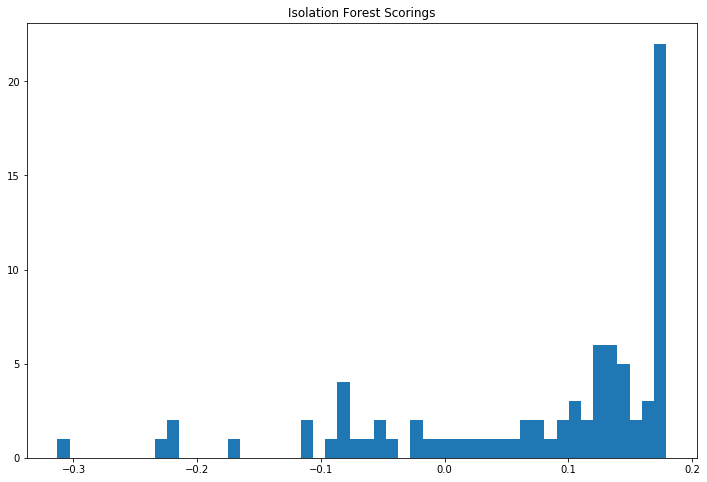

In [16]:
df_labels_outliers, df_labels = [], []
for i in range(df_agg.shape[0]):
    df_labels.append(1)
for i in range(df_outliers_agg.shape[0]):
    df_labels_outliers.append(-1)
#
# Training / Validation Splits (Inliers + Outliers)
X_df_train, X_df_validate, y_df_train, y_df_validate = train_test_split(df_agg, df_labels, test_size=test_split)
X_df_outlier_train, X_df_outlier_validate, y_df_outlier_train, y_df_outlier_validate = train_test_split(df_outliers_agg, df_labels_outliers, test_size=.5)
#
# Mixing of Inlier + Outlier data for validation purposes
X_df_train = np.concatenate((X_df_train.values, X_df_outlier_train.values), axis=0)
y_df_train = np.concatenate((np.array(y_df_train), np.array(y_df_outlier_train)), axis=0)
X_df_validate = np.concatenate((X_df_validate.values, X_df_outlier_validate.values), axis=0)
y_df_validate = np.concatenate((np.array(y_df_validate), np.array(y_df_outlier_validate)), axis=0)
#
# Building Model + Training
ifw = IsolationForestWrapper(contamination=contamination,
                             parallel_degree=parallel_degree)
print(X_df_train)
print(y_df_train)
ifw.fit_model(X=X_df_train)
#
# Evaluation
ifw.evaluate_model(X=X_df_validate, 
                   y=y_df_validate,
                   plot=True)

### Access Plan Resource Aggregation (Per Access Plan Instance)

This method attempts to tackle the problem of access plan anomolies by aggregating resources per explain plan. Notable resources which are being considered are as follows:

* COST
* CARDINALITY
* BYTES
* PARTITION_DELTA (Partition End - Partition Start)
* CPU_COST
* IO_COST
* TEMP_SPACE
* TIME

The reasoning behind these fields in particular is mainly because these columns can be aggregated together. Aggregation is carried on per access plan instance. Therefore batches are summed together with every explain plan, per timestamp. Contraty to the previous resource aggregation, whereas before plan aggregation occurred per SQL_ID class, now aggregation is carried out with every SQL_ID occurance.

In [17]:
#
# Adds a columns per SQL_ID, PLAN_HASH_VALUE grouping, which can be used to group instances together
def add_grouping_column(df, column_identifier):
    """
    Receives a pandas dataframe, and adds a new column which allows dataframe to be aggregated per 
    SQL_ID, PLAN_HASH_VALUE combination.
    
    :param: df                - Pandas Dataframe
    :param: column_identifier - String denoting matrix column to group by
    
    :return: Pandas Dataframe, with added column    
    """
    print('Shape before transformation: ' + str(df.shape))
    new_grouping_col = []
    counter = 0
    last_sql_id = df[column_identifier].iloc(0) # Starts with first SQL_ID
    for index, row in df.iterrows():
        if column_identifier == 'SQL_ID':
            if last_sql_id != row.SQL_ID:
                last_sql_id = row.SQL_ID
                counter += 1
        elif column_identifier == 'PLAN_ID':
            if last_sql_id != row.PLAN_ID:
                last_sql_id = row.PLAN_ID
                counter += 1
        else:
            raise ValueError('Column does not exist!')
        new_grouping_col.append(counter)
    #
    # Append list as new column
    new_col = pd.Series(new_grouping_col)
    df['PLAN_INSTANCE'] = new_col.values
    print('Shape after transformation: ' + str(df.shape))
    return df
#
df = add_grouping_column(df=df,column_identifier='SQL_ID')
df_outliers = add_grouping_column(df=df_outliers,column_identifier='PLAN_ID')

Shape before transformation: (10000, 30)
Shape after transformation: (10000, 31)
Shape before transformation: (1467, 14)
Shape after transformation: (1467, 15)


In [18]:
df_agg = df.groupby(['SQL_ID','PLAN_HASH_VALUE','PLAN_INSTANCE']).mean()
df_agg.reset_index(inplace=True)
#
df_outliers_agg = df_outliers.groupby(['PLAN_ID','PLAN_INSTANCE']).mean()
df_outliers_agg.reset_index(inplace=True)
#
for col in df_outliers_agg.columns:
    if col not in df_agg.columns:
        df_outliers_agg.drop(columns=[col], inplace=True)
for col in df_agg.columns:
    if col not in df_outliers_agg.columns:
        df_agg.drop(columns=[col], inplace=True)
#
df_agg.drop(columns=['PLAN_INSTANCE'], inplace=True)
df_outliers_agg.drop(columns=['PLAN_INSTANCE'], inplace=True)
#
print(df_agg.columns)
print(df_agg.shape)
print('------------------------------------------')
print(df_outliers_agg.columns)
print(df_outliers_agg.shape)

Index(['ID', 'PARENT_ID', 'DEPTH', 'POSITION', 'SEARCH_COLUMNS', 'COST',
       'CARDINALITY', 'IO_COST', 'TIME'],
      dtype='object')
(308, 9)
------------------------------------------
Index(['SEARCH_COLUMNS', 'ID', 'PARENT_ID', 'DEPTH', 'POSITION', 'COST',
       'CARDINALITY', 'IO_COST', 'TIME'],
      dtype='object')
(42, 9)


### Supervised Training (Random Forest - Per Access Plan Instance)

The following section oversees the supervised training of inlier/outlier explain plans. This section first splits the training dataset into two: train + test sets, by mixing half the outliers with the inlier training set. Validation is then performed on a 50/50 mix of inlier / outlier vectors. The ability to classify explain plan vectors as inliers / outliers will be gauged.

Labels are denoted as follows:
* Inliers  - 0
* Outliers - 1

In [19]:
df_labels_outliers, df_labels = [], []
for i in range(df_agg.shape[0]):
    df_labels.append(0)
for i in range(df_outliers_agg.shape[0]):
    df_labels_outliers.append(1)
#
# Training / Validation Splits (Inliers + Outliers)
X_df_train, X_df_validate, y_df_train, y_df_validate = train_test_split(df_agg, df_labels, test_size=test_split)
X_df_outlier_train, X_df_outlier_validate, y_df_outlier_train, y_df_outlier_validate = train_test_split(df_outliers_agg, df_labels_outliers, test_size=.5)
#
# Mixing of Inlier + Outlier data for validation purposes
X_df_train = np.concatenate((X_df_train.values, X_df_outlier_train.values), axis=0)
y_df_train = np.concatenate((np.array(y_df_train), np.array(y_df_outlier_train)), axis=0)
X_df_validate = np.concatenate((X_df_validate.values, X_df_outlier_validate.values), axis=0)
y_df_validate = np.concatenate((np.array(y_df_validate), np.array(y_df_outlier_validate)), axis=0)
#
# Building Model + Training
rfc = RandomForest(n_estimators=n_estimators,
                   max_depth=max_depth,
                   criterion=criterion,
                   parallel_degree=parallel_degree)
print(X_df_train)
print(y_df_train)
rfc.fit_model(X=X_df_train,
              y=y_df_train)
# Evaluation
rfc.predict_and_evaluate(X=X_df_validate, 
                         y=y_df_validate,
                         plot=True)

[[4.50000000e+00 3.60000000e+00 4.50000000e+00 ... 9.84518000e+04
  5.84000000e+01 2.00000000e-01]
 [1.10000000e+01 9.30434783e+00 5.78260870e+00 ... 2.47354678e+06
  1.85297826e+04 1.43478261e+00]
 [6.50000000e+00 5.21428571e+00 5.85714286e+00 ... 3.92424286e+04
  3.34014286e+03 7.85714286e-01]
 ...
 [6.66666667e-02 7.00000000e+00 5.66666667e+00 ... 3.75419820e+06
  6.32022000e+04 3.13333333e+00]
 [4.54545455e-02 1.05000000e+01 9.04545455e+00 ... 2.33997673e+06
  9.13570455e+04 4.27272727e+00]
 [8.00000000e-02 1.20000000e+01 1.02000000e+01 ... 1.71922832e+06
  2.75328800e+04 1.84000000e+00]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

### Unsupervised Learning (Isolation Forest - Per Access Plan Instance)

The following section attempts to train a generalized version of input access plans using Isolation Forests. These trained models are then used to classify access plan outliers from inlier (normal) access plans.

IsolationForest(bootstrap=False, contamination=0.05, max_features=1.0,
        max_samples=256, n_estimators=100, n_jobs=4, random_state=0,
        verbose=0)
[[1.10000000e+01 9.30434783e+00 7.86956522e+00 ... 9.66650652e+05
  1.76731739e+04 1.17391304e+00]
 [4.50000000e+00 3.60000000e+00 4.50000000e+00 ... 2.87950400e+05
  1.75200000e+02 2.00000000e-01]
 [1.50000000e+00 7.50000000e-01 1.50000000e+00 ... 2.94500000e+02
  2.75000000e+00 2.50000000e-01]
 ...
 [8.62068966e-02 2.85000000e+01 2.57931034e+01 ... 3.61222362e+05
  2.42128966e+04 1.75862069e+00]
 [1.30434783e-01 3.40000000e+01 3.01304348e+01 ... 1.32501667e+05
  6.02618841e+03 8.98550725e-01]
 [0.00000000e+00 4.50000000e+00 3.40000000e+00 ... 5.65667322e+07
  5.01724620e+06 1.96800000e+02]]
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1 

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Test Accuracy: 0.7831325301204819
Test Precision: 0.782051282051282
Test Recall: 0.9838709677419355
Test FScore: 0.8714285714285716



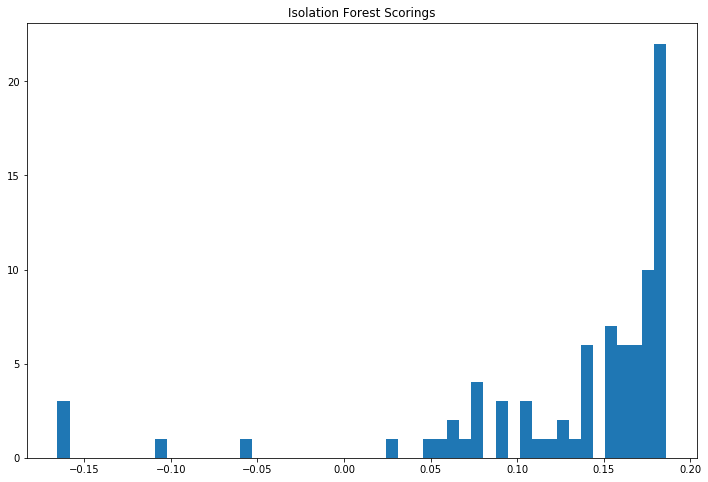

In [20]:
df_labels_outliers, df_labels = [], []
for i in range(df_agg.shape[0]):
    df_labels.append(1)
for i in range(df_outliers_agg.shape[0]):
    df_labels_outliers.append(-1)
#
# Training / Validation Splits (Inliers + Outliers)
X_df_train, X_df_validate, y_df_train, y_df_validate = train_test_split(df_agg, df_labels, test_size=test_split)
X_df_outlier_train, X_df_outlier_validate, y_df_outlier_train, y_df_outlier_validate = train_test_split(df_outliers_agg, df_labels_outliers, test_size=.5)
#
# Mixing of Inlier + Outlier data for validation purposes
X_df_train = np.concatenate((X_df_train.values, X_df_outlier_train.values), axis=0)
y_df_train = np.concatenate((np.array(y_df_train), np.array(y_df_outlier_train)), axis=0)
X_df_validate = np.concatenate((X_df_validate.values, X_df_outlier_validate.values), axis=0)
y_df_validate = np.concatenate((np.array(y_df_validate), np.array(y_df_outlier_validate)), axis=0)
#
# Building Model + Training
ifw = IsolationForestWrapper(contamination=contamination,
                             parallel_degree=parallel_degree)
print(X_df_train)
print(y_df_train)
ifw.fit_model(X=X_df_train)
#
# Evaluation
ifw.evaluate_model(X=X_df_validate, 
                   y=y_df_validate,
                   plot=True)